# Simulating Language, Lab 8, Evolving a communication system

In lab 9 we are going to look at a full co-evolutionary model, with a culturally-evolving language transmitted through iterated learning in a population whose priors are evolving. This lab is a stepping-stone towards that full model - we are going to build a model of genetic evolution (a genetic algorithm), and use it to look at the evolution of an innate signalling system, where the communicative behaviour of individuals is determined entirely by their genes.

## Sketch of our genetic algorithm

As covered in the lecture 8 reading, a genetic algorithm consists of a number of components:
1. A population of choromosomes (i.e. a representation of the genes of each individual in the population).
2. A model of selection (i.e. which individuals get to reproduce?)
3. A model of reproduction and mutation (i.e. how are new chromosomes formed?)


## Model of chromosomes 

In our case we are going to model each individual as a collection of `n_genes` (this is a parameter - you can set it to 20, 50, 100 etc) binary genes (i.e. each gene has one of two possible values, 0 or 1). So if `n_genes` is set to 20, here are three possible chromosomes:

```python
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
[0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]
```

These genes will determine each individual's communicative behaviour (this is a model of innate signalling: unlike for human language, your communicative behaviour does not depend on learning from experience, only your genes). Then selection will be determined by communicative behaviour - individuals whose genes result in succesful communication will be more likely to reproduce. This means we need a model of communication.

## Model of communication

For our model of communocation we are going to use the good-old , for which we are going to use the good-old beta-binomial model from labs 3-4 - but since this is a model of innate signalling, we can forget about learning from data for now. 

Recall that in the beta-binomial model we assume there are two words (or if you prefer, two signals), word 0 and word 1. Each individual's signalling behaviour is characterised by a single probability, `pW1`, the probability that they will produce word 1 (and the probability that they produce word 0 is `1-pW1`). In labs 3-4 we used the beta distribution as the prior - we specified a parameter $\alpha$, and then our prior was given by a $\beta$ distribution $\beta(\alpha,\alpha)$. Importantly, this is *symmetrical* - in our prior, learners perferred or dispreferred regularity depending on the value of the alpha parameter, but they never had a preference for word 0 over word 1, or vice versa. However, we can easily relax this assumption by plugging in two different parameters to the beta distribution, let's call them $\alpha_0$ and $\alpha_1$. If $\alpha_0$ is greater than $\alpha_1$ then $\beta(\alpha_0,\alpha_1)$ puts more weight on word 0, and if $\alpha_1$ is greater than $\alpha_0$ then $\beta(\alpha_0,\alpha_1)$ puts more weight on word 1, as you can see in the plot below (today we will always be working with alpha values less than 1). 

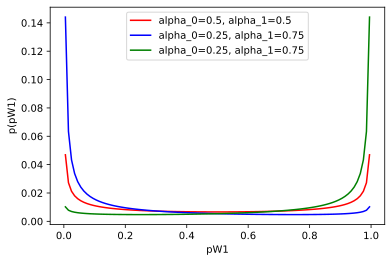

In [1]:
from scipy.stats import beta

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

#this code is all borrowed from lab 3
grid_granularity = 100 #How many values of pW1 do you want to consider? Setting this to 100.
grid_increment = 1 / grid_granularity
 
possible_pW1 = []
for i in range(grid_granularity):
    possible_pW1.append(grid_increment / 2 + (grid_increment * i))
    
def normalize_probs(probs):
    total = sum(probs) #calculates the summed probabilities
    normedprobs = []
    for p in probs:
        normedprobs.append(p / total) #normalise - divide by summed probs
    return normedprobs

def calculate_prior(alpha_0,alpha_1):
    prior = []
    for pW1 in possible_pW1:
        prior.append(beta.pdf(pW1, alpha_0, alpha_1)) #look up the value using beta.pdf and add to our growing prior
    return normalize_probs(prior) #normalize the final list so they are all probabilities
    
plt.plot(possible_pW1, calculate_prior(0.5,0.5),'red',label="alpha_0=0.5, alpha_1=0.5")
plt.plot(possible_pW1, calculate_prior(0.25,0.75),'blue',label="alpha_0=0.25, alpha_1=0.75")
plt.plot(possible_pW1, calculate_prior(0.75,0.25),'green',label="alpha_0=0.25, alpha_1=0.75")
plt.xlabel("pW1")
plt.ylabel("p(pW1)")
plt.legend()

This is how we are going to model communication: each individual has a `pW1` determined by their genes which determines how often they use word 0 and word 1, and two individuals succesfully communicate if they choose to use the same word on any given instance (this is a very simplistic model of communication!). So pairs of individuals whose genes encode similar and extreme values of $\alpha_0$ and $\alpha_1$ will tend to communicate succesfully quite often, and pairs of individuals whose genes encode extreme and *different* values of those parameters will communicate succesfully very seldom. 

Theone remaining issue is how each individual's genes determine $\alpha_0$ and $\alpha_1$. Remember that the genes in our chromosomes are binary - each gene is 0 or 1. To determine $\alpha_0$ for an individual we just count up what proportion of their genes are 0s; to determine $\alpha_1$ we count the proportion of the chromosome made up of gene 1. Then since the beta distribution breaks if we have any 0 values we add a small number (0.01) to each. So for the three chromosomes above, the values will be:

`[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]`: $\alpha_0$=1.01, $\alpha_1$=0.01

`[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]`: $\alpha_0$=0.01, $\alpha_1$=1.01

`[0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]`: $\alpha_0$=0.51, $\alpha_1$=0.51

## Model of selection

We'll save this for below, but the idea is that in our population we simulate a large number of communicative episodes between individuals, and the individuals who succesfully communicate more often are more likely to be selected to reproduce and pass on their genes to the next generation.

## Model of reproduction

Again, you can see this below, but the model allows us to model both *asexual* reproduction (each individual has a single parent, who they are genetically indentical to apart from mutation) and *sexual* reproduction (each individual has two parents, whose genes are combined and then mutated to build the offspring genotype).

## The Code

### Loading libraries etc

We start by pulling in some library functions we need, and setting up plotting in the usual way (note that some of these functions were already loaded to produce the plots above, but I am re-entering them here in case you skip running that cell above). 

In [2]:
import random

from scipy.stats import beta
from copy import deepcopy #we will explain this where we use it below


%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

#roulette_wheel and normalize_probs should be familiar from earlier labs
def roulette_wheel(normedprobs):
    r=random.random() #generate a random number between 0 and 1
    accumulator = normedprobs[0]
    for i in range(len(normedprobs)):
        if r < accumulator:
            return i
        accumulator = accumulator + normedprobs[i + 1]

def normalize_probs(probs):
    total = sum(probs) #calculates the summed probabilities
    normedprobs = []
    for p in probs:
        normedprobs.append(p / total) #normalise - divide by summed probs
    return normedprobs

### Simulation parameters

In [3]:
n_genes = 50
reproduction = 'asexual'        # Do individuals have 1 parent ('asexual') or 2 ('sexual')?
mutation_rate = 0.001           # Per-gene probability of mutation
popsize = 100                   # Size of population
n_interactions = popsize*100    # Number of interactions per generation - on average 100 per individual
n_variants = 2                  # Number of linguistic variants - at various places the code needs to know this 

### Communication and fitness evaluation

Evolutionary algorithms require a function which measures fitness and helps determine which agents will reproduce into the next generation. In our model this is going to depend on communication between individuals. We are going to represent individuals as a list of 4 items:

1. Their genes (which is itself a list).
2. Their probability of using word 1, `pW1` (which depends on their genes).
3. A number indicating how many succesful communicative interactions they have had.
4. A number indicating how many communicative interactions they have had (succesful or not).

So for instance, here's the representation for an individual with a 10 genes (all 0s), so has `pW1` of 0.1, has had 7 succesful communicative interactions out of 10 interactions total.

```python
an_individual = [[0,0,0,0,0,0,0,0,0,0],0.1,7,10]
```

A population is then just a list of individuals represented in this way.

Now we have a model of individuals and populations, we can model production by individuals and communication between individuals. The `produce` function is from lab 3, and simply has an individual produce a number of words based on their `pW1`. `communicate` takes 2 individuals and models a very simple kind of communication: they both produce a single word, if the words they produce match they score the communication as a success and return a score of 1, otherwise it's a failure and we return a score of 0.

In [4]:
#this is from lab 3
def produce(pW1, n_productions):
    pW0 = 1- pW1
    probs = [pW0, pW1]
    data = []
    for p in range(n_productions):
        data.append(roulette_wheel(probs))
    return data

def communicate(agent1, agent2):
    agent1_variant = produce(agent1[1],1) #speaker[1] retrieves the speaker's value of pW1
    agent2_variant = produce(agent2[1],1)
    if agent1_variant == agent2_variant:
        return 1
    else:
        return 0

Now we can model communication between pairs we can assess the fitness of a whole population, by simulating many such pairwise interactions. `assess_fitness` does this, simulating `n_interactions` (one of our parameters) interactions between randomly-selected individuals in the populatuon (with the constraint that individuals don't talk to themselves). 

`get_fitness` simply counts, for a given individual, what proportion of interactions they were involved in were succesful, and `get_pop_fitness` does this for an entire population.

In [5]:
def assess_fitness(population):
    for i in range(n_interactions):
        agent1_index = None #not picked our speaker or hearer yet
        agent2_index = None
        #keep picking at random until we get two agents who are not the same individual!
        while agent1_index == agent2_index:
            agent1_index = random.randrange(len(population))
            agent2_index = random.randrange(len(population))
        agent1 = population[agent1_index]
        agent2 = population[agent2_index]
        success = communicate(agent1, agent2)
        agent1[2] += success
        agent1[3] += 1
        agent2[2] += success
        agent2[3] += 1

def get_fitness(agent):
    n_successes = agent[2]
    n_interactions = agent[3]
    return (n_successes/n_interactions) + 0.01 #small constant to ensure everyone has some small chance of being selected
    
def get_pop_fitness(population):
    fitness_list = []
    for agent in population:
        fitness_list.append(get_fitness(agent))
    return fitness_list

### Reproduction and mutation

When individuals are selected to reproduce we need to use their genes to build genes for new individuals - children inherit their genes from their parent(s). The model includes both asexual (1 parent) and sexual (2 parent) reproduction. In both cases we create a new chromosome from the parent chromosome(s), then apply mutation, which randomly scrambles each gene in the offspring genotype with some small probability.

In *asexual* reproduction things are simple: the offspring simply inherits a copy of their parent's genes, which then undergoes mutation. However, in python you need to be careful copying lists, so we use the `deepcopy` function we load above. To see why, run this bit of code, where we try to 'copy' a list using the = operator. 

In [6]:
a = [0,1,2,3]
b = a #try to copy a and call it b
b[0] = 99 #set the first value of list b to something new
print(b)
print(a)

[99, 1, 2, 3]
[99, 1, 2, 3]


Aaargh! Changing list b also changed list a, because actually a and b are pointers to the *same* underlying list. Scary. To avoid this nasty behaviour we can use deepcopy to make a new copy of a list, as below.

In [7]:
a = [0,1,2,3]
b = deepcopy(a) 
b[0] = 99 #set the first value of list b to something new
print(b)
print(a)

[99, 1, 2, 3]
[0, 1, 2, 3]


That looks more sensible. So `asexual_reproduce` uses deepcopy to copy the parent chromosome, then mutates the new offspring chromosome.

Sexual reproduction is a bit more complicated. Each individual has two parents, and their genes are combined by crossover: we take the first portion of the genes from 1 parent, then the rest from the other parent, with the crossover point being selected randomly so that the offspring is guaranteed to get at least some genetic material from each parent. Then we mutate the new chromosome we have created.

In [8]:
def asexual_reproduce(parent):
    parent_genotype = parent[0] #parent[0] pulls out the parent's genes 
    offspring_genotype = deepcopy(parent_genotype)
    mutate(offspring_genotype)
    return offspring_genotype

def sexual_reproduce(parent1,parent2):
    parent1_genotype = parent1[0]
    parent2_genotype = parent2[0]
    offspring_genotype = crossover(parent1_genotype,parent2_genotype)
    mutate(offspring_genotype)
    return offspring_genotype

def crossover(genotype1,genotype2):
    crosspoint = random.randrange(1,n_genes) #a random crosspoint between 1 and n_genes - 1
    offspring_genotype = genotype1[:crosspoint] + genotype2[crosspoint:]
    return offspring_genotype

def mutate(genotype):
    for gene_i in range(len(genotype)):
        if random.random() < mutation_rate: #with small probability
            genotype[gene_i] = random.randrange(n_variants) #set this gene to a new random value 

### Setting pW1 from the genes

Now we can use each individual's genes to set their value of `pW1`, the probability with which they use word 1. To do this we just need to count up the number of 0s and 1s in their genes, convert those to proportions (this is done by `count_genes`) and then use those values of $\alpha_0$ and $\alpha_1$ to sample a value of `pW1` according to the beta distribution (done by `sample_pW1`). 

Note that `count_genes` uses the built-in `count` function, which very handily counts occurences of some specified value in a list.

In [9]:
#want to know proportion of all the variants in the genome, since this determines the prior
def count_genes(genotype):
    variant0_count = genotype.count(0)
    variant1_count = genotype.count(1)
    variant0_proportion = variant0_count/n_genes
    variant1_proportion = variant1_count/n_genes
    return variant0_proportion,variant1_proportion

#sample a value of pW1 based on the beta distribution. Note that to prevent a maths error where either alpha 
#value is 0, we add a small constant (0.01) to both.
def sample_pW1(alpha0,alpha1):
    sampled_pW1 = beta.rvs(alpha1+0.01,alpha0+0.01)
    return sampled_pW1

### Establishing a random population of agents

We need to do is generate a random population to start each run of the model: each initial population consists of individuals who have random genes, with `pW1` values depoending on those genes in the usual way. The function `random_genotype` generates a random genotype, and this is used to generate a random population of agents (`random_population`).

In [10]:
def random_genotype():
    genotype = []
    for i in range(n_genes):
        genotype.append(random.randrange(n_variants)) #will generate 0s and 1s for all genes
    return genotype

def random_population(size):
    population = []
    for i in range(size):
        genotype = random_genotype()
        alpha0,alpha1 = count_genes(genotype) 
        pW1 = sample_pW1(alpha0,alpha1) #set pW1 based on the genes
        random_agent = [genotype,pW1,0,0] #build the agent
        population.append(random_agent)
    return population

### Breeding the next generation of agents

Now we have nearly all the pieces in place,we just need to put the various bits together. The `new_population` function specifies how to take an existing population and breed a new population of agents based on the existing population. The probability of being picked as a parent agent is proportional to the agent’s fitness, and then depending on whether `reproduction` is set to `asexual` or `sexual` we breed offspring from one or two parents until we have made enough for a new population.

In [11]:
def new_population(population):
    population_fitness_list = get_pop_fitness(population)
    #normalise these fitness scores so they are scaled to 0-1, probability of being selected to reproduce
    reproduction_probabilities = normalize_probs(population_fitness_list)
    new_population = []
    for i in range(popsize):
        #select parent(s) and reproduce
        parent_index = roulette_wheel(reproduction_probabilities)
        parent = population[parent_index]
        if reproduction == 'asexual':
            child_genotype = asexual_reproduce(parent)
        elif reproduction == 'sexual':
            parent2_index = parent_index
            while parent2_index==parent_index: #need two distinct parents for sexual reproduction (!)
                parent2_index = roulette_wheel(reproduction_probabilities)
            parent2 = population[parent2_index]
            child_genotype = sexual_reproduce(parent,parent2)
        
        #count the child's genes to get their prior
        child_alpha0,child_alpha1 = count_genes(child_genotype)
        child_pW1 = sample_pW1(child_alpha0,child_alpha1)
        child = [child_genotype,child_pW1,0,0]
        new_population.append(child)
    return new_population

### Some final bits of book-keeping

As we run the model it's going to be nice to track fitness in the population (i.e. on average how often a randomly-selected pair of agents communicate succesfully), but also what the population's genes and pW1 values look like. These two functions just sample this information. 

In [12]:
def count_pop_genes(population):
    gene1count_list = []
    for agent in population:
        agent_genotype = agent[0]
        agent_gene0_count,agent_gene1_count = count_genes(agent_genotype)
        gene1count_list.append(agent_gene1_count)
    return gene1count_list

def get_pop_pW1(population):
    pW1_list = []
    for agent in population:
        agent_pW1 = agent[1]
        pW1_list.append(agent_pW1)
    return pW1_list

### Running the simulation (at last)

OK, so now we can run the model and see if we can get communication to evolve. `simulation` does all the work here, initialising with a randomly-generated population and running a specified number of generations. As it goes it tracks a bunch of statistics: it returns the final population, and then three lists, each containing 1 value per generation: the average fitness at that generation, the average proportion of gene 1 in the population's genes, and the average value of `pW1` in the population. Watching how these change over time will let you see how the population's communication system is evolving.

In [13]:
def simulation(generations):
    average_fitness_accumulator=[]
    average_genotype_accumulator=[]
    average_pW1_accumulator=[]
    population = random_population(popsize) #initialise from random
    for i in range(generations):
        assess_fitness(population) #assess fitness of all individuals in population
        
        fitness_list = get_pop_fitness(population) #retrieve fitness of every agent in the population
        average_fitness = sum(fitness_list)/popsize #calculate the average fitness
        average_fitness_accumulator.append(average_fitness) #and log it
        
        gene1count_list = count_pop_genes(population) #count proportion of gene 1 per individual
        average_gene1count = sum(gene1count_list)/popsize #calculate the average
        average_genotype_accumulator.append(average_gene1count) #and log it
        
        pW1_list = get_pop_pW1(population) #retrieve pW1 per individual
        average_pW1 = sum(pW1_list)/popsize #calculate the average
        average_pW1_accumulator.append(average_pW1) #and log it
        
        population = new_population(population)#generate new population, and repeat!
    
    #after the necessary number of generations have been run
    return [population, average_fitness_accumulator,average_genotype_accumulator,average_pW1_accumulator]

Here's how you use the code with the default parameter settings, plotting a graph showing fitness, gene counts and pW1 values over 5000 generations. This will take about 6 minutes to run. If you find that too frustrating, you can reduce the number of genes (e.g. to 20) and run for 1000 generations.

```python
my_pop, average_fitness_list,average_genecount_list,average_pW1_list = simulation(5000)
plt.plot(average_fitness_list,color='blue',label="Average fitness")
plt.plot(average_pW1_list,color='green', label="Average proportion gene 1")
plt.plot(average_genecount_list,color='red', label="Average pW1")
```

## Questions

1. Can you evolve a population with a shared signalling system which allows them to communicate reliably? How is this achieved? Is it a slow process or a fast process?

2. Can you speed up evolution (or slow it down)? How? Is there a limit to how fast evolution can happen in the model? Is there a limit to the maximal level of communicatiev accuracy a population can achieve?

3. Does asexual or sexual reproduction work best? Why do you think that is?

4. In this model a parent’s signalling behaviour is transmitted directly to their offspring via the genes. In lab 4 we saw how to use a similar model to model cultural transmission. In lab 9 we are going to combine these two models. How would you adapt this code to achieve that?

5. This is quite a basic genetic algorithm - there are fancier crossover models (e.g. multiple crossover points), other ways you could model selection (e.g. reproduce from the fittest N individuals), and 'smart' mutation operators that target particular kinds of individuals or genes for mutation. Have a go at improving the genetic algorithm so communication evolves more rapidly.